In [ ]:
!file /content/drive/MyDrive/archive.zip

/content/drive/MyDrive/archive.zip: Zip archive data, at least v4.5 to extract, compression method=deflate


In [ ]:
!apt-get install -y p7zip-full
!7z l /content/drive/MyDrive/archive.zip
!7z x /content/drive/MyDrive/archive.zip -o/content/data

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
2019-10-13 05:53:00 .....         2128         2133  train/5/00005_00054_00007.png
2019-10-13 05:53:00 .....         2171         2176  train/5/00005_00054_00008.png
2019-10-13 05:53:00 .....         2541         2546  train/5/00005_00054_00009.png
2019-10-13 05:53:00 .....         2513         2518  train/5/00005_00054_00010.png
2019-10-13 05:53:00 .....         2596         2601  train/5/00005_00054_00011.png
2019-10-13 05:53:00 .....         2537         2542  train/5/00005_00054_00012.png
2019-10-13 05:53:00 .....         2529         2534  train/5/00005_00054_00013.png
2019-10-13 05:53:00 .....         2798         2803  train/5/00005_00054_00014.png
2019-10-13 05:53:00 .....         2618         2623  train/5/00005_00054_00015.png
2019-10-13 05:53:00 .....         2810         2815  train/5/00005_00054_00016.png
2019-10-13 05:53:00 .....         2754         2759  train/5/00005_00054_00017.png
2019-10-13 05:53:00 .....     

/content/drive/MyDrive/archive.zip: Zip archive data, at least v4.5 to extract, compression method=deflate
Phát hiện file CSV: ['Train.csv', 'Meta.csv', 'Test.csv']
Kích thước dataframe: (39209, 8)
Các cột: Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  
Số lượng mẫu: 39209
Số lượng lớp: 43


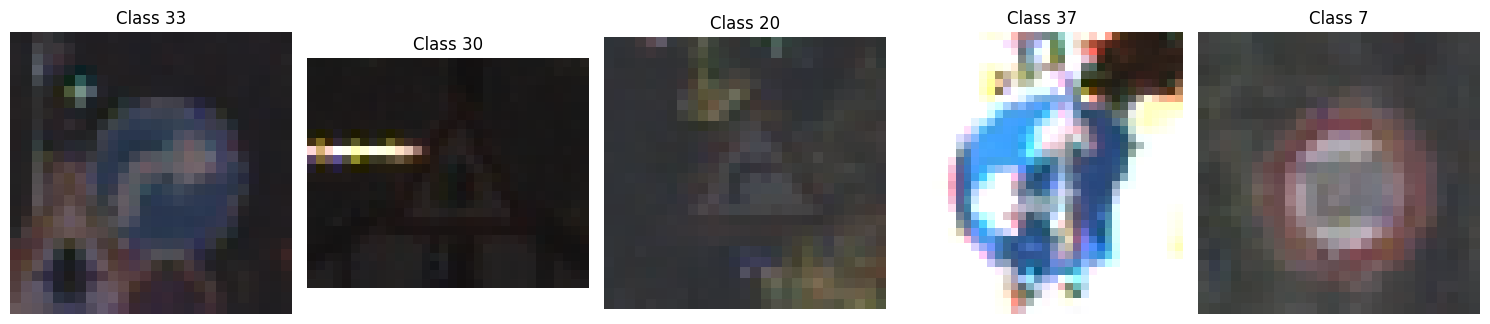

📊 Kết quả đánh giá:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       0.94      0.96      0.95       444
           2       0.92      0.93      0.93       450
           3       0.96      0.94      0.95       282
           4       0.98      0.99      0.99       396
           5       0.92      0.91      0.92       372
           6       1.00      1.00      1.00        84
           7       0.98      0.95      0.97       288
           8       0.96      0.97      0.96       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       1.00      1.00      1.00       126
          16       1.00      1.00      1.00        84
       

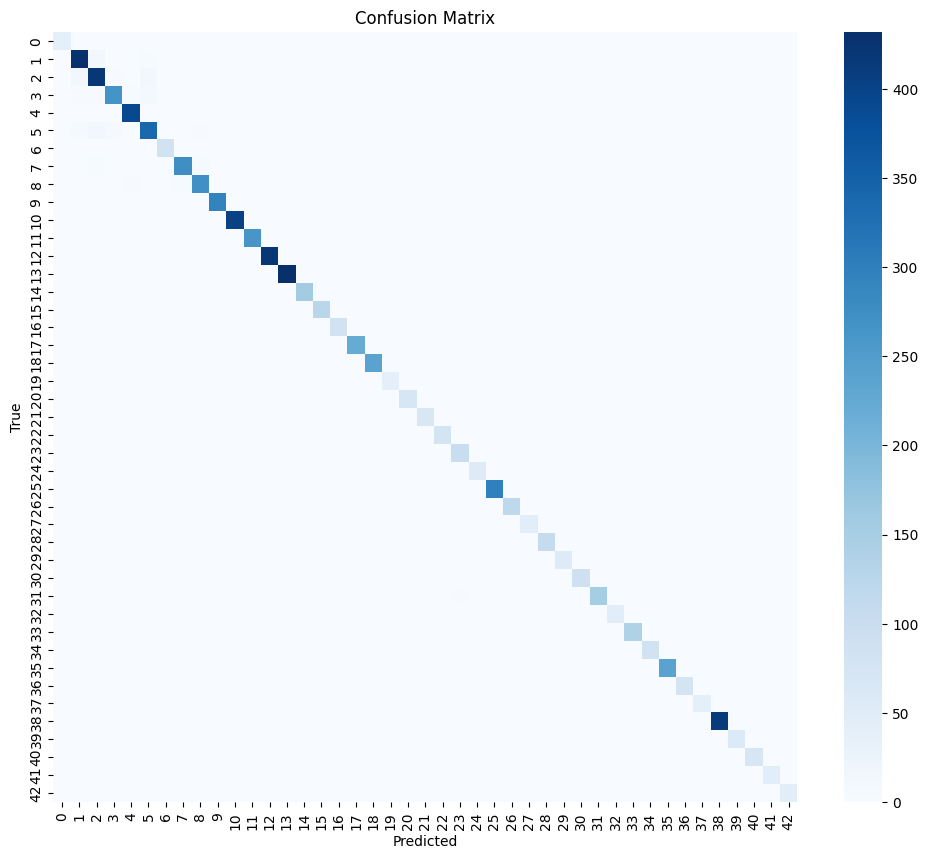

✅ Đã lưu mô hình vào svm_traffic_sign.pkl
👉 Nhập đường dẫn ảnh cần dự đoán (cách nhau bởi dấu phẩy): /content/data/Test/00034.png, /content/data/Test/00066.png, /content/data/Test/00087.png, /content/data/Test/00104.png

🔎 Đang dự đoán cho ảnh: /content/data/Test/00034.png


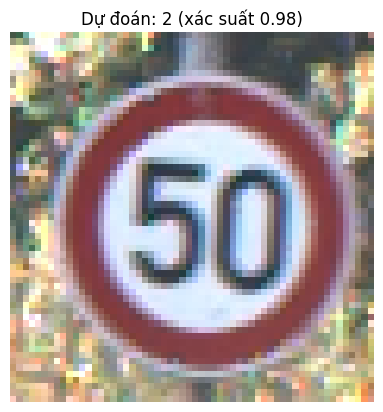


🔎 Đang dự đoán cho ảnh: /content/data/Test/00066.png


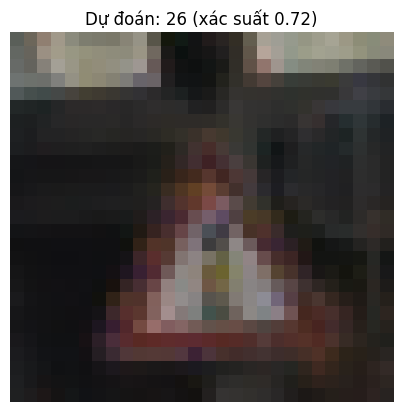


🔎 Đang dự đoán cho ảnh: /content/data/Test/00087.png


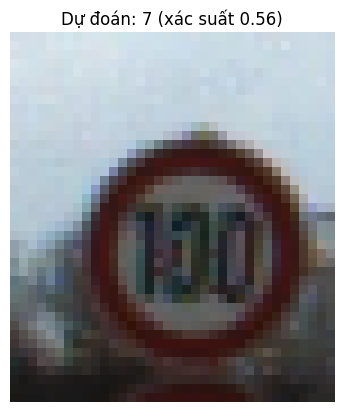


🔎 Đang dự đoán cho ảnh: /content/data/Test/00104.png


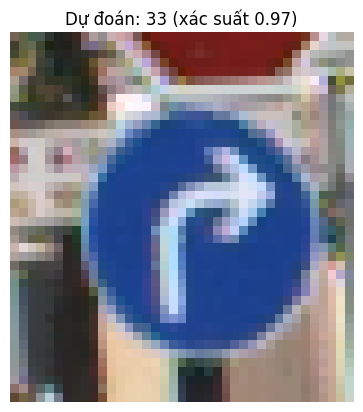

In [ ]:
# Cài đặt các thư viện cần thiết
!pip install scikit-image

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Thêm accuracy_score
import seaborn as sns
from skimage.feature import hog
import joblib
import random

!file /content/drive/MyDrive/archive.zip

# Đường dẫn đến thư mục dữ liệu sau khi giải nén
data_dir = "/content/data"

# ========================
# 1. Khám phá dữ liệu + hiển thị mẫu ảnh
# ========================
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
if len(csv_files) > 0:
    print("Phát hiện file CSV:", csv_files)
    df = pd.read_csv(os.path.join(data_dir, csv_files[0]))
    print("Kích thước dataframe:", df.shape)
    print("Các cột:", df.columns)
    print(df.head())

    # Hiển thị số lượng mẫu
    print("Số lượng mẫu:", len(df))

    # Hiển thị số lượng lớp
    num_classes = df['ClassId'].nunique()
    print("Số lượng lớp:", num_classes)

    # Hiển thị một số ảnh mẫu từ vài lớp ngẫu nhiên
    sample_classes = random.sample(list(df['ClassId'].unique()), 5)
    fig, axes = plt.subplots(1, len(sample_classes), figsize=(15,5))
    for idx, class_id in enumerate(sample_classes):
        sample = df[df['ClassId'] == class_id].iloc[0]
        img_path = os.path.join(data_dir, sample['Path'])
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            axes[idx].set_title(f"Class {class_id}")
            axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

else:
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    num_classes = len(classes)
    print("Số lượng lớp:", num_classes)

    # Hiển thị một số ảnh từ vài lớp
    sample_classes = random.sample(classes, 5)
    fig, axes = plt.subplots(1, len(sample_classes), figsize=(15,5))
    for idx, label in enumerate(sample_classes):
        class_dir = os.path.join(data_dir, label)
        img_files = [f for f in os.listdir(class_dir) if f.lower().endswith((".png",".jpg",".jpeg",".ppm",".bmp"))]
        if len(img_files) > 0:
            img_path = os.path.join(class_dir, img_files[0])
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[idx].imshow(img)
                axes[idx].set_title(f"Class {label}")
                axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

# ========================
# 2. Tiền xử lý + Augmentation
# ========================
IMG_SIZE = 64

def preprocess_image(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    return img

def augment_image(img):
    h, w = img.shape[:2]
    variants = []
    # Lật ngang
    variants.append(cv2.flip(img, 1))
    # Xoay ±15°
    for angle in [-15, 15]:
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        rotated = cv2.warpAffine(img, M, (w, h))
        variants.append(rotated)
    return variants

# ========================
# 3. Trích xuất đặc trưng HOG
# ========================
def extract_features(images):
    features = []
    for img in images:
        fd = hog(img, orientations=9, pixels_per_cell=(8,8),
                 cells_per_block=(2,2), block_norm='L2-Hys')
        features.append(fd)
    return np.array(features)

# ========================
# 4. Ma trận nhầm lẫn
# ========================
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# ========================
# 6. Huấn luyện SVM + hiển thị kết quả
# ========================
X, y = [], []

if len(csv_files) > 0:
    for idx, row in df.iterrows():
        img_path = os.path.join(data_dir, row['Path'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        proc = preprocess_image(img)
        feat = extract_features([proc])[0]
        X.append(feat)
        y.append(row['ClassId'])
else:
    for label in classes:
        class_dir = os.path.join(data_dir, label)
        img_files = [f for f in os.listdir(class_dir) if f.lower().endswith((".png",".jpg",".jpeg",".ppm",".bmp"))]
        for f in img_files:
            img_path = os.path.join(class_dir, f)
            img = cv2.imread(img_path)
            if img is None:
                continue
            proc = preprocess_image(img)
            feat = extract_features([proc])[0]
            X.append(feat)
            y.append(int(label))

X = np.array(X)
y = np.array(y)

# Tách train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Huấn luyện SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

print("📊 Kết quả đánh giá:")
print(classification_report(y_test, y_pred))
# Hiển thị độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Độ chính xác của mô hình SVM: {accuracy*100:.2f}%")

# Hiển thị ma trận nhầm lẫn
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y))

# Lưu mô hình
joblib.dump(svm_model, "svm_traffic_sign.pkl")
print("✅ Đã lưu mô hình vào svm_traffic_sign.pkl")

# ========================
# 7. Hàm dự đoán nhiều ảnh mới (nhập thủ công)
# ========================
def extract_hog_features(img):
    fd = hog(img, orientations=9, pixels_per_cell=(8,8),
             cells_per_block=(2,2), block_norm='L2-Hys')
    return fd

def preprocess_image_path(img_path, augment=False):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Không đọc được ảnh.")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    return img

def predict_image(img_path, model):
    try:
        img = preprocess_image_path(img_path)
    except Exception as e:
        print("❌ Không thể đọc ảnh:", img_path, "Lỗi:", e)
        return None

    feat = extract_hog_features(img).reshape(1, -1)
    pred = model.predict(feat)[0]
    prob = model.predict_proba(feat)[0]

    # Hiển thị ảnh + nhãn
    img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Dự đoán: {pred} (xác suất {prob.max():.2f})")
    plt.show()
    return pred, prob

# --- Nhập nhiều ảnh để test ---
test_imgs = input("👉 Nhập đường dẫn ảnh cần dự đoán (cách nhau bởi dấu phẩy): ").strip().split(',')

for img_path in test_imgs:
    img_path = img_path.strip()
    if os.path.exists(img_path) and img_path != "":
        print(f"\n🔎 Đang dự đoán cho ảnh: {img_path}")
        predict_image(img_path, svm_model)
    else:
        print(f"⚠️ Ảnh không tồn tại: {img_path}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
